In [7]:
import pandas as pd
import sys
import os
import importlib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Configurar el path para poder importar tools
# El notebook está en ENTREGABLES/marcos/, necesitamos subir un nivel a ENTREGABLES/
current_dir = os.getcwd()
# Si estamos en marcos/, subir un nivel
if current_dir.endswith('marcos'):
    entregables_dir = os.path.dirname(current_dir)
else:
    # Si no, buscar el directorio ENTREGABLES en el path actual
    entregables_dir = current_dir
    while not os.path.exists(os.path.join(entregables_dir, 'tools.py')):
        parent = os.path.dirname(entregables_dir)
        if parent == entregables_dir:  # Llegamos a la raíz
            break
        entregables_dir = parent

if os.path.exists(os.path.join(entregables_dir, 'tools.py')):
    if entregables_dir not in sys.path:
        sys.path.insert(0, entregables_dir)
    print(f"✅ Path configurado: {entregables_dir}")
else:
    print("⚠️ No se encontró el archivo tools.py. Verifica la estructura del proyecto.")

# Importar y recargar el módulo tools para asegurar que tenemos la versión más reciente
import tools
importlib.reload(tools)  # Recargar el módulo para obtener los cambios más recientes
from tools import (
    seleccionar_variables, 
    plot_costo_interactivo, 
    evaluate_model_with_thresholds, 
    evaluate_model,
    optimizar_threshold_costo_cv,
    optimizar_threshold_f1_cv
)

print("✅ Módulo tools recargado e importado correctamente")



✅ Path configurado: c:\Users\marca\OneDrive\AUSTRAL\2do año\2do cuat\TRP II\mercado-libre-fraude-2025\ENTREGABLES
✅ Módulo tools recargado e importado correctamente


In [8]:
df = pd.read_csv("../../DATA/processed/fraud_dataset_processed.csv")

df = seleccionar_variables(df, remove_score=True)

df = df.drop(columns=['producto_nombre'])
df = df.drop(columns=['pais'])
df = df.drop(columns=['categoria_id'])

In [9]:
# ============================================================================
# PIPELINE COMPLETO DEL MODELO
# ============================================================================
# 1. Preparar datos
# 2. Entrenar modelos (uno con CV para optimizar thresholds, otro con todos los datos)
# 3. Optimizar thresholds (costo y F1) con CV
# 4. Evaluar modelo con ambos thresholds
# ============================================================================

# Preparar variables predictoras y target
X = df.drop(columns=['fraude'])
y = df['fraude']

# Split en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("=" * 80)
print("PASO 1: ENTRENAR MODELOS")
print("=" * 80)

# Configurar Random Forest
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

rf_cv = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, class_weight='balanced', n_jobs=-1)
rf_final = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42, class_weight='balanced', n_jobs=-1)

# Configurar Cross-Validation (5 folds estratificados)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n✅ Modelos configurados:")
print(f"   - rf_cv: Para optimización de thresholds con CV")
print(f"   - rf_final: Para evaluación final con todos los datos de entrenamiento")

# Entrenar modelo final con todos los datos de entrenamiento (para evaluación)
print(f"\n🎯 Entrenando modelo final con todos los datos de entrenamiento...")
rf_final.fit(X_train, y_train)

# Predicciones en el conjunto de test
y_proba_test = rf_final.predict_proba(X_test)[:, 1]

print(f"\n✅ Modelo final entrenado")
print(f"   - Probabilidades en test: {len(y_proba_test)} muestras")



PASO 1: ENTRENAR MODELOS

✅ Modelos configurados:
   - rf_cv: Para optimización de thresholds con CV
   - rf_final: Para evaluación final con todos los datos de entrenamiento

🎯 Entrenando modelo final con todos los datos de entrenamiento...

✅ Modelo final entrenado
   - Probabilidades en test: 50000 muestras


In [10]:
# ============================================================================
# PASO 2: OPTIMIZAR THRESHOLDS CON CROSS-VALIDATION
# ============================================================================

print("=" * 80)
print("PASO 2: OPTIMIZAR THRESHOLDS CON CROSS-VALIDATION")
print("=" * 80)

# Parámetros de costo
costo_fp = 5.0
costo_fn = 100.0

# Calcular probabilidades de CV una sola vez (para evitar recalcular los folds)
print("\n📊 Calculando probabilidades con Cross-Validation...")
from sklearn.model_selection import cross_val_predict
y_proba_cv = cross_val_predict(rf_cv, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
print(f"✅ Probabilidades de CV calculadas: {len(y_proba_cv)} muestras")

# Optimizar threshold por costo usando CV
print("\n🔍 Optimizando threshold por función de costo...")
resultado_costo = optimizar_threshold_costo_cv(
    model=rf_cv,
    X=X_train,
    y=y_train,
    cv=cv,
    costo_fp=costo_fp,
    costo_fn=costo_fn,
    model_name="Random Forest",
    y_proba_cv=y_proba_cv  # Reutilizar las probabilidades ya calculadas
)

threshold_optimo_costo = resultado_costo['threshold_optimo']
costo_minimo = resultado_costo['costo_minimo']

# Optimizar threshold por F1 Score usando CV
print("\n🔍 Optimizando threshold por F1 Score...")
resultado_f1 = optimizar_threshold_f1_cv(
    model=rf_cv,
    X=X_train,
    y=y_train,
    cv=cv,
    model_name="Random Forest",
    y_proba_cv=y_proba_cv  # Reutilizar las probabilidades ya calculadas
)

threshold_optimo_f1 = resultado_f1['threshold_optimo']
f1_maximo = resultado_f1['f1_maximo']

print("\n" + "=" * 80)
print("RESUMEN DE THRESHOLDS ÓPTIMOS:")
print("=" * 80)
print(f"📌 Threshold óptimo (Costo): {threshold_optimo_costo:.4f}")
print(f"   Costo mínimo: {costo_minimo:.2f} por 1000 registros")
print(f"\n📌 Threshold óptimo (F1 Score): {threshold_optimo_f1:.4f}")
print(f"   F1 Score máximo: {f1_maximo:.4f}")


PASO 2: OPTIMIZAR THRESHOLDS CON CROSS-VALIDATION

📊 Calculando probabilidades con Cross-Validation...


✅ Probabilidades de CV calculadas: 200000 muestras

🔍 Optimizando threshold por función de costo...

🎯 OPTIMIZACIÓN DE THRESHOLD POR COSTO (CV):
   Threshold óptimo: 0.5804
   Costo mínimo por 1000 registros: 1611.75
   FP ajustado: 26050
   FN ajustado: 1921

📊 EVALUACIÓN DE ROBUSTEZ:
   Coeficiente de variación (CV): 0.0288
   Robustez: Muy robusto ✅
   Costo medio por fold: 1611.75 ± 46.38

🔍 Optimizando threshold por F1 Score...

🎯 OPTIMIZACIÓN DE THRESHOLD POR F1 SCORE (CV):
   Threshold óptimo: 0.7722
   F1 Score máximo: 0.3226
   Precision: 0.2906
   Recall: 0.3625

📊 EVALUACIÓN DE ROBUSTEZ:
   Coeficiente de variación (CV): 0.0504
   Robustez: Muy robusto ✅
   F1 Score medio por fold: 0.3226 ± 0.0163

RESUMEN DE THRESHOLDS ÓPTIMOS:
📌 Threshold óptimo (Costo): 0.5804
   Costo mínimo: 1611.75 por 1000 registros

📌 Threshold óptimo (F1 Score): 0.7722
   F1 Score máximo: 0.3226


PASO 3: EVALUAR MODELO CON THRESHOLDS ÓPTIMOS

EVALUACIÓN CON THRESHOLD ÓPTIMO (COSTO)
EVALUACIÓN DEL MODELO: Random Forest - Threshold Costo (0.5804)

📌 Threshold usado: 0.5804

📊 DISTRIBUCIÓN DE CLASES:
   Clase 0 (No Fraude): 48,500 (97.00%)
   Clase 1 (Fraude):    1,500 (3.00%)
   Total:               50,000

🎯 MÉTRICAS PRINCIPALES:
   Accuracy:            0.8598
   F1 Score:            0.2306 ⭐
   Precision:           0.1380
   Recall (Sensitivity): 0.7007
   Specificity:         0.8647
   ROC AUC:             0.8702
   Average Precision:   0.2852

📈 MÉTRICAS ADICIONALES:
   Cohen's Kappa:       0.1900
   Matthews Corr Coef:  0.2684
   NPV:                 0.9894
   False Positive Rate: 0.1353

📊 RESUMEN DE MÉTRICAS CLAVE:
   Precision:          0.1380
   Recall:             0.7007
   F1 Score:           0.2306
   Cohen's Kappa:      0.1900
   Matthews Corr Coef: 0.2684
   Tasa positivos:     0.1523

💰 COSTO:
   Costo por 1000 registros: 1554.30
   (Costo FP: 5.0, Costo FN: 100.0)

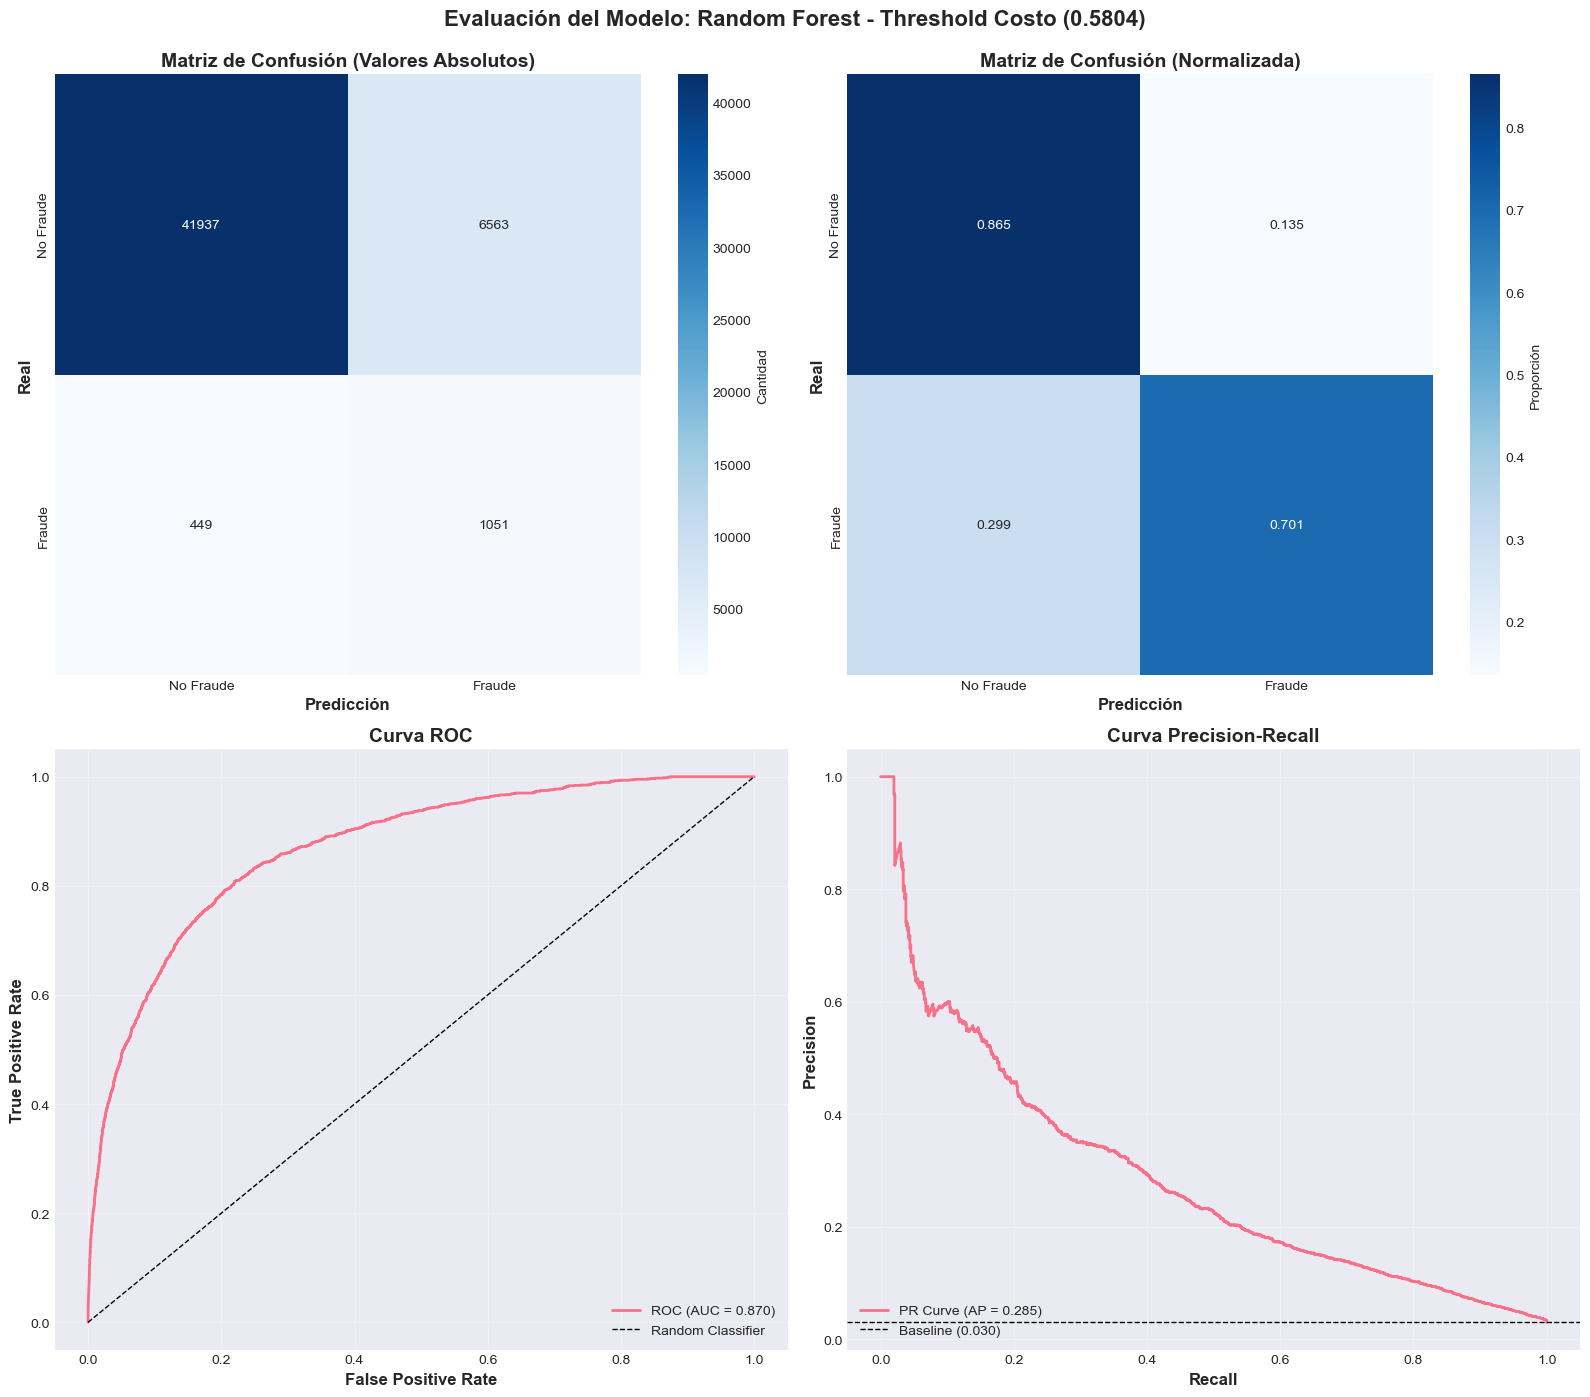

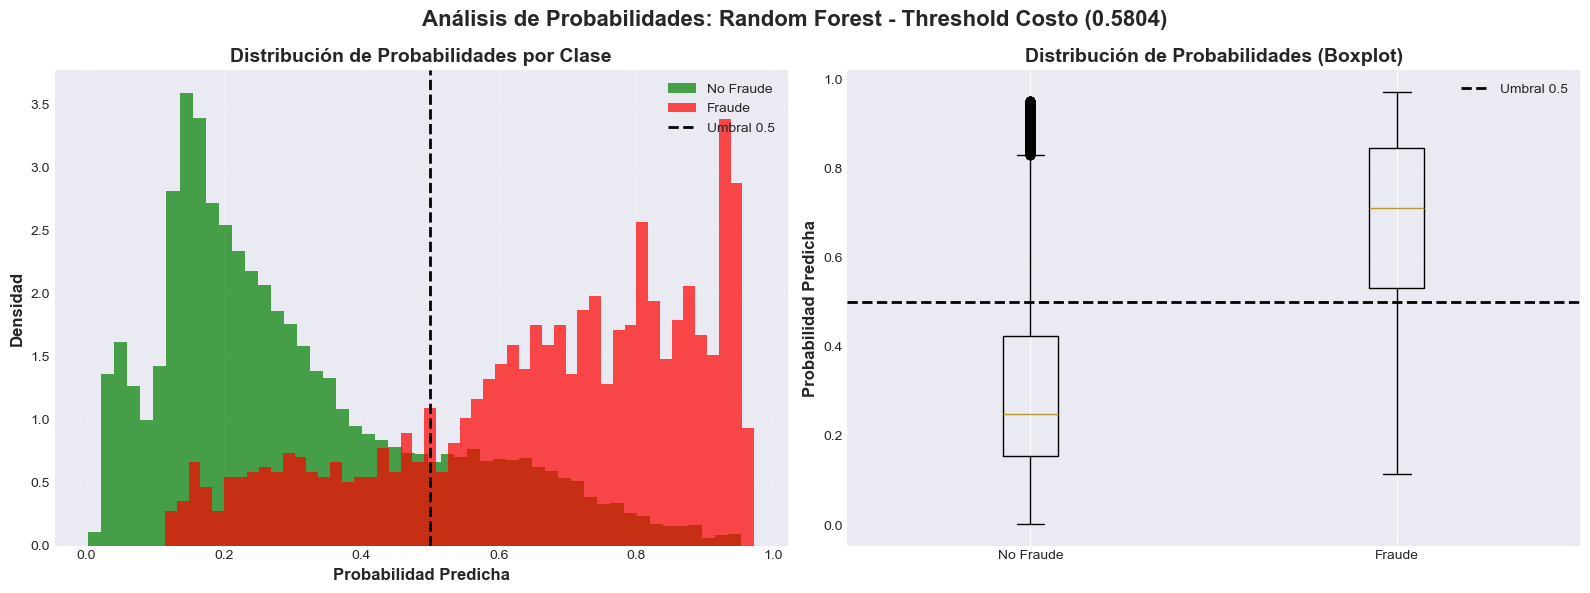


EVALUACIÓN CON THRESHOLD ÓPTIMO (F1 SCORE)
EVALUACIÓN DEL MODELO: Random Forest - Threshold F1 (0.7722)

📌 Threshold usado: 0.7722

📊 DISTRIBUCIÓN DE CLASES:
   Clase 0 (No Fraude): 48,500 (97.00%)
   Clase 1 (Fraude):    1,500 (3.00%)
   Total:               50,000

🎯 MÉTRICAS PRINCIPALES:
   Accuracy:            0.9532
   F1 Score:            0.3384 ⭐
   Precision:           0.2940
   Recall (Sensitivity): 0.3987
   Specificity:         0.9704
   ROC AUC:             0.8702
   Average Precision:   0.2852

📈 MÉTRICAS ADICIONALES:
   Cohen's Kappa:       0.3148
   Matthews Corr Coef:  0.3187
   NPV:                 0.9812
   False Positive Rate: 0.0296

📊 RESUMEN DE MÉTRICAS CLAVE:
   Precision:          0.2940
   Recall:             0.3987
   F1 Score:           0.3384
   Cohen's Kappa:      0.3148
   Matthews Corr Coef: 0.3187
   Tasa positivos:     0.0407

💰 COSTO:
   Costo por 1000 registros: 1947.60
   (Costo FP: 5.0, Costo FN: 100.0)

🔢 MATRIZ DE CONFUSIÓN:
                    P

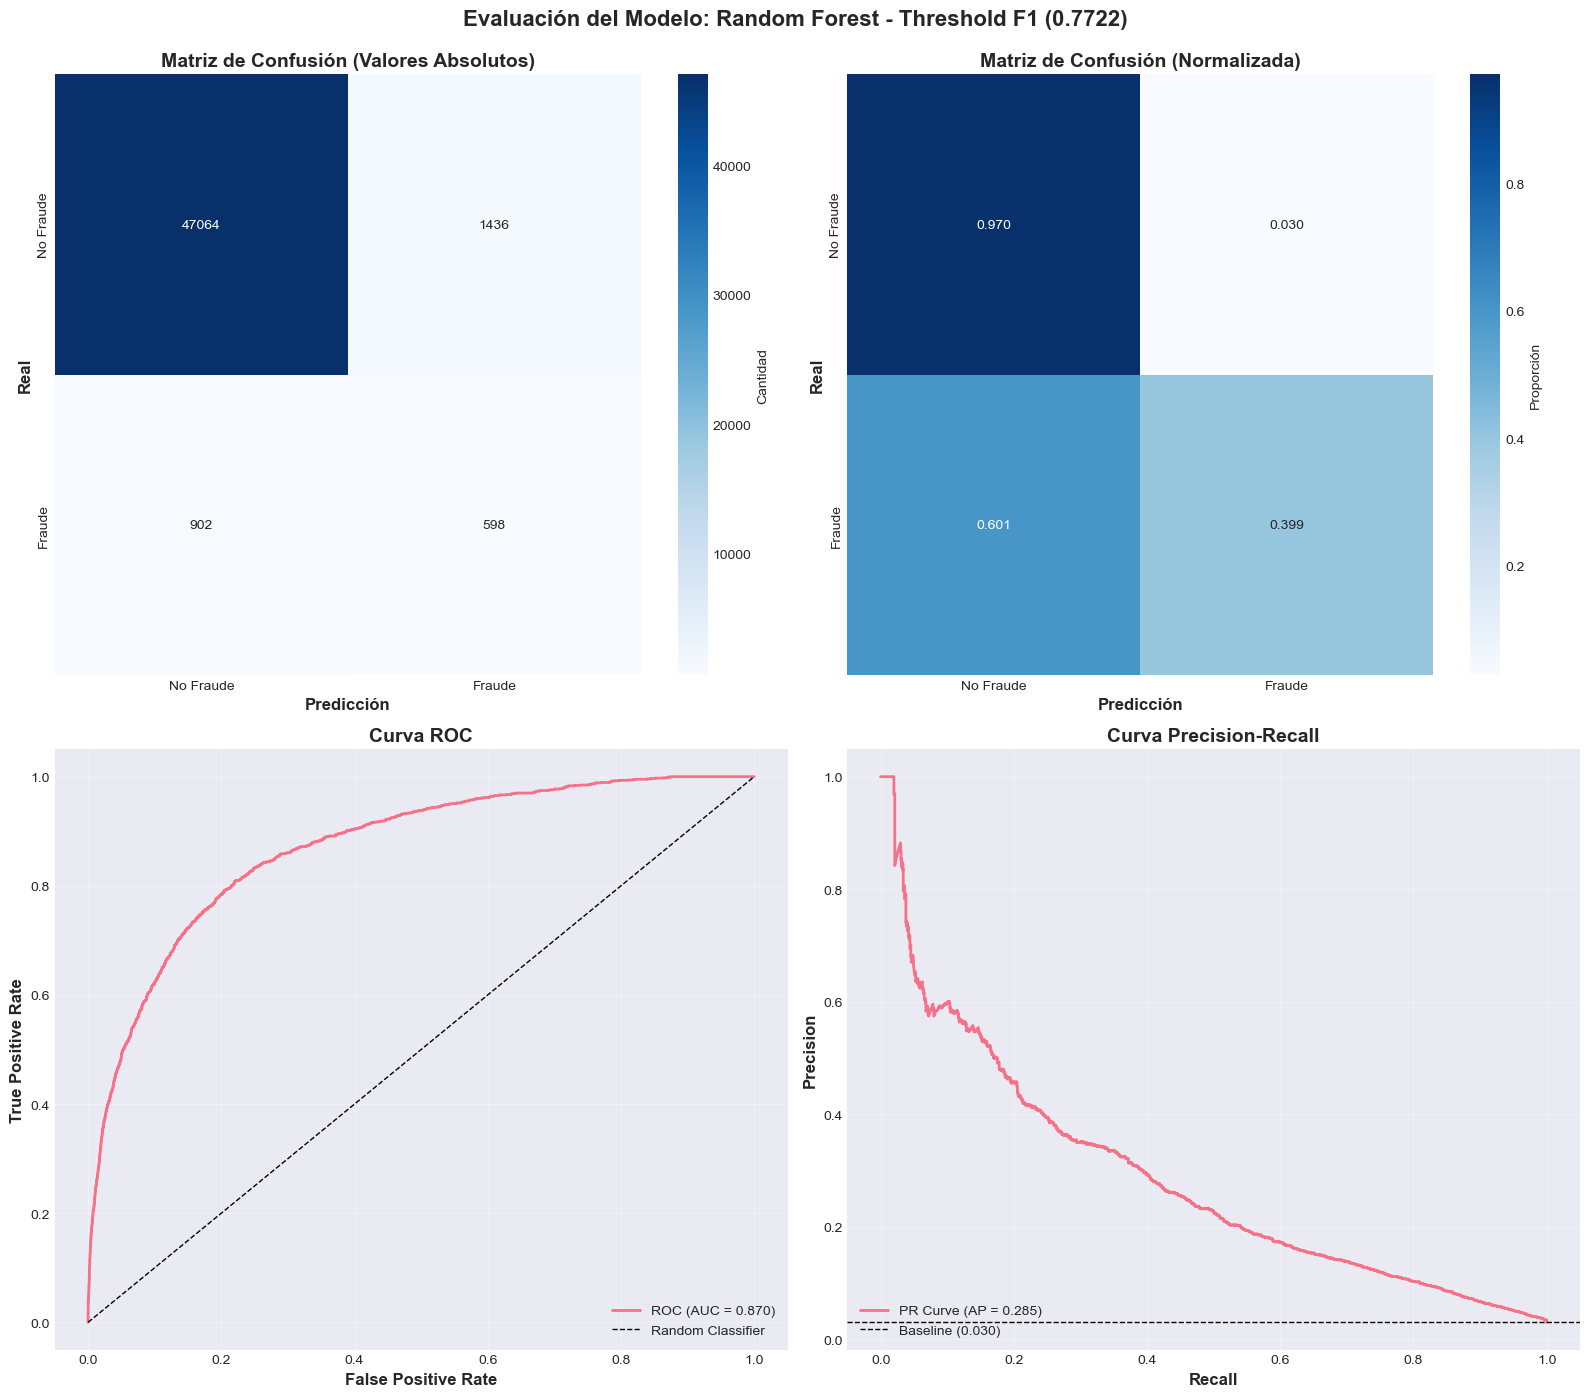

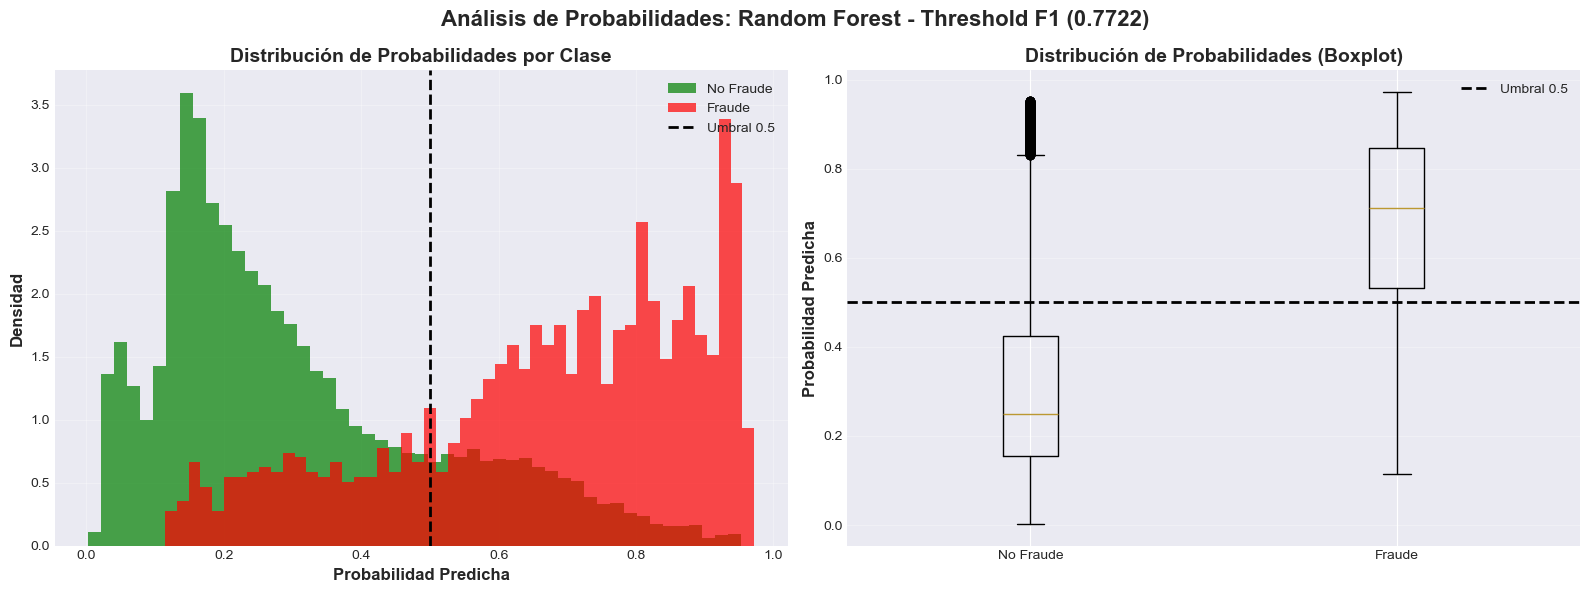

In [11]:
# ============================================================================
# PASO 3: EVALUAR MODELO CON AMBOS THRESHOLDS
# ============================================================================

print("=" * 80)
print("PASO 3: EVALUAR MODELO CON THRESHOLDS ÓPTIMOS")
print("=" * 80)

# Evaluar con threshold óptimo de costo
print("\n" + "=" * 80)
print("EVALUACIÓN CON THRESHOLD ÓPTIMO (COSTO)")
print("=" * 80)

metrics_costo = evaluate_model(
    y_true=y_test,
    y_proba=y_proba_test,
    threshold=threshold_optimo_costo,
    model_name=f"Random Forest - Threshold Costo ({threshold_optimo_costo:.4f})",
    costo_fp=costo_fp,
    costo_fn=costo_fn
)

# Evaluar con threshold óptimo de F1
print("\n" + "=" * 80)
print("EVALUACIÓN CON THRESHOLD ÓPTIMO (F1 SCORE)")
print("=" * 80)

metrics_f1 = evaluate_model(
    y_true=y_test,
    y_proba=y_proba_test,
    threshold=threshold_optimo_f1,
    model_name=f"Random Forest - Threshold F1 ({threshold_optimo_f1:.4f})",
    costo_fp=costo_fp,
    costo_fn=costo_fn
)


In [12]:
# ============================================================================
# IMPORTANCIA DE VARIABLES
# ============================================================================

print("=" * 80)
print("IMPORTANCIA DE VARIABLES (Ordenadas de mayor a menor)")
print("=" * 80)

# Obtener importancias del modelo final
importancias = rf_final.feature_importances_
variables = X_train.columns

# Crear DataFrame con importancias
df_importancias = pd.DataFrame({
    'Variable': variables,
    'Importancia': importancias
})

# Ordenar de mayor a menor
df_importancias = df_importancias.sort_values('Importancia', ascending=False).reset_index(drop=True)

# Agregar porcentaje acumulado
df_importancias['Importancia_%'] = df_importancias['Importancia'] * 100
df_importancias['Importancia_Acumulada_%'] = df_importancias['Importancia_%'].cumsum()

# Mostrar todas las variables
print(f"\n📊 Total de variables: {len(df_importancias)}")
print(f"\n{'Rank':<6} {'Variable':<40} {'Importancia':<15} {'%':<10} {'% Acum.':<10}")
print("-" * 85)

for idx, row in df_importancias.iterrows():
    print(f"{idx+1:<6} {row['Variable']:<40} {row['Importancia']:<15.6f} {row['Importancia_%']:<10.2f} {row['Importancia_Acumulada_%']:<10.2f}")

# Mostrar top 10
print("\n" + "=" * 80)
print("TOP 10 VARIABLES MÁS IMPORTANTES:")
print("=" * 80)
print(df_importancias.head(10)[['Variable', 'Importancia', 'Importancia_%']].to_string(index=False))

# Mostrar estadísticas
print("\n" + "=" * 80)
print("ESTADÍSTICAS DE IMPORTANCIA:")
print("=" * 80)
print(f"   - Importancia máxima: {df_importancias['Importancia'].max():.6f} ({df_importancias['Importancia'].max()*100:.2f}%)")
print(f"   - Importancia mínima: {df_importancias['Importancia'].min():.6f} ({df_importancias['Importancia'].min()*100:.2f}%)")
print(f"   - Importancia media:  {df_importancias['Importancia'].mean():.6f} ({df_importancias['Importancia'].mean()*100:.2f}%)")
print(f"   - Desviación estándar: {df_importancias['Importancia'].std():.6f} ({df_importancias['Importancia'].std()*100:.2f}%)")
print(f"\n   - Variables con >1% de importancia: {(df_importancias['Importancia_%'] > 1).sum()}")
print(f"   - Variables con >0.5% de importancia: {(df_importancias['Importancia_%'] > 0.5).sum()}")
print(f"   - Variables con <0.1% de importancia: {(df_importancias['Importancia_%'] < 0.1).sum()}")


IMPORTANCIA DE VARIABLES (Ordenadas de mayor a menor)

📊 Total de variables: 16

Rank   Variable                                 Importancia     %          % Acum.   
-------------------------------------------------------------------------------------
1      o                                        0.420862        42.09      42.09     
2      a                                        0.104353        10.44      52.52     
3      f                                        0.104028        10.40      62.92     
4      l                                        0.075422        7.54       70.47     
5      n                                        0.069754        6.98       77.44     
6      m                                        0.056718        5.67       83.11     
7      s                                        0.027796        2.78       85.89     
8      d                                        0.026412        2.64       88.53     
9      b                                        0.025823   